In [1]:
# Run the pre-processing

# %run 'pre-processing.ipynb'

In [2]:
import pandas as pd

PROCESSED_DATA_FOLDER = '../processed_data/'

PROCESSED_CHARACTER = PROCESSED_DATA_FOLDER + 'character_metadata.csv'
PROCESSED_MOVIE = PROCESSED_DATA_FOLDER + 'movie_metadata.csv'

characters_df = pd.read_csv(PROCESSED_CHARACTER)
movie_df = pd.read_csv(PROCESSED_MOVIE)

### Freebase database

Many features in our datasets have as format freebase ids. It is essential to be able to translate these features to their respective labels to properly understand our datasets and make precise analysis. This is why we made an auxiliary function to make queries to the freebase database.

In [3]:
import requests
import urllib
import numpy as np


'''
:param list of string
:return dictionnary with id and it's translation

Uses queries to the wikidata database
'''
def translate_freebase_list(freebase_ids) -> dict:
    st = "\" \"".join(freebase_ids)
    st = "\"" + st + "\""

    query_content = """
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

    SELECT DISTINCT ?ISNI ?idLabel WHERE {
    VALUES ?ISNI {%s}
    ?id wdt:P646 ?ISNI
    SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
    }
    }
    """ % st
    
    query = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=" + urllib.parse.quote_plus(query_content)
    response = requests.get(query)
    if not response.ok :
        print("Error in request")
        return np.NaN
    
    values = response.json()
    if len(values) == 0 :
        return np.NaN
        
    return dict([(item['ISNI']['value'], item['idLabel']['value']) for item in values['results']['bindings']])

#split a list into n pieces
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

#add a translated column (of the col_name given) to the dataframe
def translate_freebase_df(df, col_name) :
    li = list(set(df[col_name].dropna().tolist()))
    di = dict()
    for l in split(li, 10) :
        di.update(translate_freebase_list(l))
    
    df[col_name + '_translated'] = df[col_name].apply(lambda x : di[x] if x in di else np.NaN)
    return df

In [4]:

translated_characters_df = characters_df.copy()
translate_freebase_df(translated_characters_df, 'actor_ethnicity')

#print only rows where actor ethnicity is not null
translated_characters_df[['wikipedia_movie_id', 'actor_name', 'actor_ethnicity', 'actor_ethnicity_translated']].\
    loc[translated_characters_df['actor_ethnicity'].notna()].dropna().head(n=5)

,wikipedia_movie_id,actor_name,actor_ethnicity,actor_ethnicity_translated
2,975900,Ice Cube,/m/0x67,African Americans
5,975900,Pam Grier,/m/0x67,African Americans
11,975900,Rodney A. Grant,/m/064b9n,Omaha people
27,3196793,Albert Hall,/m/0x67,African Americans
55,2314463,Seth Green,/m/041rx,Jewish people


### Initial observations

Let's begin with some analysis. For that we are going to need the ratio of women actors per movie.

In [5]:
movie_gender = characters_df.groupby(['wikipedia_movie_id', 'actor_gender']).size().unstack(fill_value=0)
movie_gender['ratio'] = movie_gender['F'] / (movie_gender['M'] + movie_gender['F'])
movie_gender = movie_gender['ratio'].reset_index()

We are going to plot the ratio of female actors in movie over the years.

We can see that the ratio increases from 1940 to date but still remains below 0.37 which is intriguing. There is also an interesting period between 1920 and 1940 where the ratios are relatively high, it goes around 0.37, can we maybe link it to the particular history in those times ? We will continue those analysis in milestone 3.  

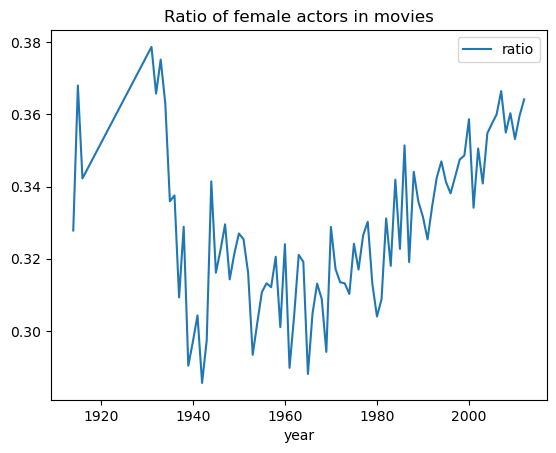

In [6]:
#merge the movie dates using wikipedia ids
movie_gender_date = pd.merge(movie_gender, movie_df[['wikipedia_movie_id', 'movie_release_date']], on='wikipedia_movie_id').dropna()
movie_gender_date['year'] = pd.DatetimeIndex(movie_gender_date['movie_release_date']).year.astype('int')

#group the movies by year and drop years with less than 275 movies
movie_gender_date = movie_gender_date[movie_gender_date.groupby('year')['year'].transform('size') >= 275].\
    groupby('year')['ratio'].mean().reset_index()

#plot the graph
movie_gender_date.plot(x='year', y='ratio', kind='line', title='Ratio of female actors in movies');


### Additional dataset

One additional that we are going to use is the collection of the plot summaries, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref).

This dataset will be useful to help us understand the role of female characters in the different movies.

We are using the Element Tree module to parse the XML data. 

In [7]:
import xml.etree.ElementTree as ET

DATA = '../corenlp_plot_summaries/'

def parse_nlp(id : str) -> ET :
    tree = ET.parse(DATA + id + '.xml')
    return tree.getroot()

In [8]:
#Let's get a movie with a character anyone knows: the great Batman
batman_character = characters_df[['wikipedia_movie_id', 'character_name']].loc[characters_df['character_name'] == 'Batman'].iloc[1]

#Use the function in auxiliary.ipynb to get the element tree root from the xml file
root = parse_nlp(str(batman_character['wikipedia_movie_id']))

#Make a dic of all the words linked to Batman during the movie
words = dict()
for dep in root.findall("document/sentences/sentence/basic-dependencies/dep/[dependent='Batman']"):
    if dep.attrib['type'] in words :
        words[dep.attrib['type']].append(dep.find('governor').text)
    else :
        words[dep.attrib['type']] = [dep.find('governor').text]


#Spoiler alert ! We can see the connected characters to our batman in 'conj' 
# (A conjunct is the relation between two elements connected by a conjunction word)
print("Character connected : " + str(words['conj']))

#Or we can see Batman's actions using the nominal subject
print("Nominal subject : " + str(words['nsubj']))



Character connected : ['Joker']
Nominal subject : ['intercepts', 'gives', 'made', 'interrogate', 'interrupting', 'confronts', 'asked', 'intervenes', 'tells', 'expresses', 'lets', 'says', 'has', 'declines', 'knocks']
